In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [106]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [107]:
dict_data_lot = unpickle('data_batch_1')
X = dict_data_lot[b'data']
y = np.asarray(dict_data_lot[b'labels']).astype(np.int64)
batch_files = ['data_batch_2','data_batch_3','data_batch_4','data_batch_5']

In [108]:
dict_data_lot = unpickle('test_batch')
X_test = dict_data_lot[b'data']
y_test = np.asarray(dict_data_lot[b'labels']).astype(np.int64)

In [109]:
for file in batch_files:
    dict_data_lot = unpickle(file)
    X = np.append(X,dict_data_lot[b'data'],axis=0)
    y = np.append(y,dict_data_lot[b'labels'],axis=0)  

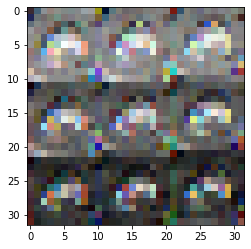

In [110]:
plt.imshow(X[0].reshape(32,32,3))

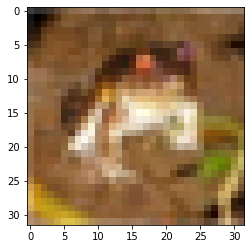

In [7]:
plt.imshow(X[0].reshape(3,32,32).transpose(1,2,0))

In [8]:
#Takes 25 mins approx
#print("Start ="+str(datetime.now()))
#max_depth_grid = [100, 150, 200, 400, 600, 800]
#accuracies = np.empty((len(max_depth_grid), 2))
#for i, max_depth in enumerate(max_depth_grid):
#    dtree = DecisionTreeClassifier(random_state=0, max_depth=max_depth)
#    dtree.fit(X, y)
#    accuracies[i,0] = accuracy_score(y, dtree.predict(X))
#    accuracies[i,1] = accuracy_score(y_test, dtree.predict(X_test))
#print("End ="+str(datetime.now()))

In [9]:
#for i, str_set in enumerate(['Training Set', 'Test Set']):
#    plt.plot(max_depth_grid, accuracies[:,i], label=str(str_set)+' Accuracy')
#plt.legend()
#plt.xlabel('Max depth')
#plt.ylabel('Accuracy')
#plt.show()

In [10]:
#No improvement in accuracy for deicion tree.

In [11]:
# Check if CUDA is available
gpu_present = torch.cuda.is_available()
   
if gpu_present:
    print("Training can be done on a GPU...")
else:
    print("Training can only be done on a CPU...")

Training can only be done on a CPU...


In [12]:
#Tringing pytorch CNN

In [13]:
scaler = MinMaxScaler(copy=True, feature_range=(-1, 1))
scaler.fit(X)
X_rescaled = scaler.transform(X).astype(np.float32)
X_test_rescaled = scaler.transform(X_test).astype(np.float32)

In [14]:
train_img_tensor_x = torch.from_numpy(X_rescaled.reshape(50000,3,32,32))
train_img_tensor_y = torch.from_numpy(y)
test_img_tensor_x = torch.from_numpy(X_test_rescaled.reshape(10000,3,32,32))
test_img_tensor_y = torch.from_numpy(y_test)

trainset = utils.TensorDataset(train_img_tensor_x,train_img_tensor_y)
testset = utils.TensorDataset(test_img_tensor_x,test_img_tensor_y)

trainloader = utils.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testloader = utils.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

In [15]:
#Neural Network for a three channel image
class CIFAR_CNN_Net(nn.Module):
    def __init__(self):
        super(CIFAR_CNN_Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64 * 4 * 4)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
CIFAR_CNN = CIFAR_CNN_Net()

# Move tensors to GPU is CUDA is available
if gpu_present:
    CIFAR_CNN.cuda()

In [16]:
#Let’s use a Classification Cross-Entropy loss and SGD with momentum.
#Define a Loss function and optimizer

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(CIFAR_CNN.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#Train the network

In [ ]:
model_path = 'CIFAR-10-CNN-MODEL.pt'
num_epochs = 10

for epoch in range(1, num_epochs+1):  # loop over the dataset multiple times

    training_loss = 0.0
    CIFAR_CNN.train()
    for i, data in enumerate(trainloader, 0):
        

        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        if gpu_present:
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = CIFAR_CNN(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

#        if i % 2000 == 1999:    # print every 2000 mini-batches
#            print('[%d, %5d] loss: %.3f' %
#                  (epoch + 1, i + 1, running_loss / 2000))
#            running_loss = 0.0

    training_loss = training_loss/len(trainloader.dataset)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, training_loss))    
    
print('Finished Training....')
torch.save(CIFAR_CNN.state_dict(), model_path)
print('Saved model parameters to disk.')

In [ ]:
#Testing the network

In [ ]:
CIFAR_CNN.eval()
total_correct = 0
total_images = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # move tensors to GPU if CUDA is available
        if gpu_present:
            images, labels = images.cuda(), labels.cuda()     
        outputs = CIFAR_CNN(images)
        # convert output probabilities to predicted class
        _, predicted = torch.max(outputs.data, 1)
        total_images += labels.size(0)
        total_correct += (predicted == labels).sum().item()

model_accuracy = total_correct / total_images * 100
print('Model accuracy on {0} test images: {1:.2f}%'.format(total_images, model_accuracy))

In [ ]:
#Activation Maximization

In [18]:
CIFAR_CNN.load_state_dict(torch.load('CIFAR-10-CNN-MODEL.pt'))

<All keys matched successfully>

In [114]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


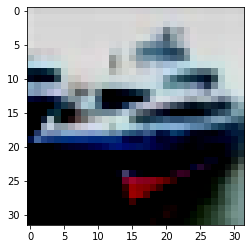

In [195]:
y = example_data[1].numpy()
plt.imshow(y.reshape(3,32,32).transpose(1,2,0))

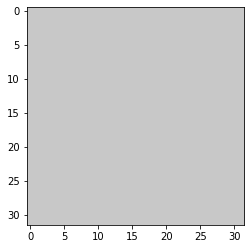

In [207]:
random_img = np.uint8(np.random.uniform(200,200, (32,32,3)))/255
random_img_tensor = torch.from_numpy(random_img.reshape(1,3,32,32).astype(np.float32))
random_img_tensor.requires_grad = True
plt.imshow(random_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


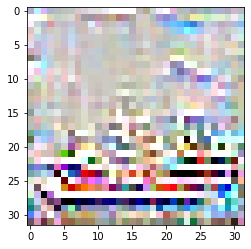

In [208]:
for i in range(25):
    output = CIFAR_CNN(random_img_tensor)
    output[0][8].backward() #Ship has class 8
    random_img_tensor.data += 0.2*random_img_tensor.grad.data
    random_img_tensor.grad.data.zero_()
    
plt.imshow(random_img_tensor.detach().numpy().reshape(3,32,32).transpose(1,2,0))    

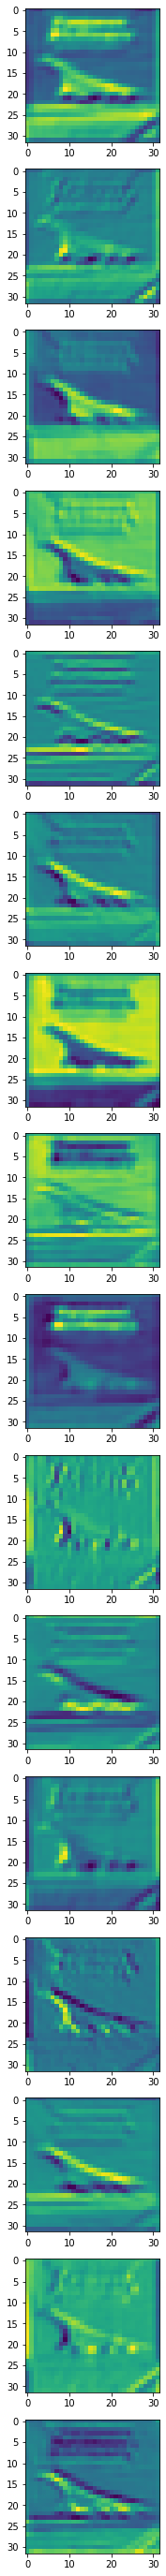

In [34]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

CIFAR_CNN.conv1.register_forward_hook(get_activation('conv1'))
image = example_data[3]
image.unsqueeze_(0)
output = CIFAR_CNN(image)
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
fig.set_size_inches(50,50)
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])   

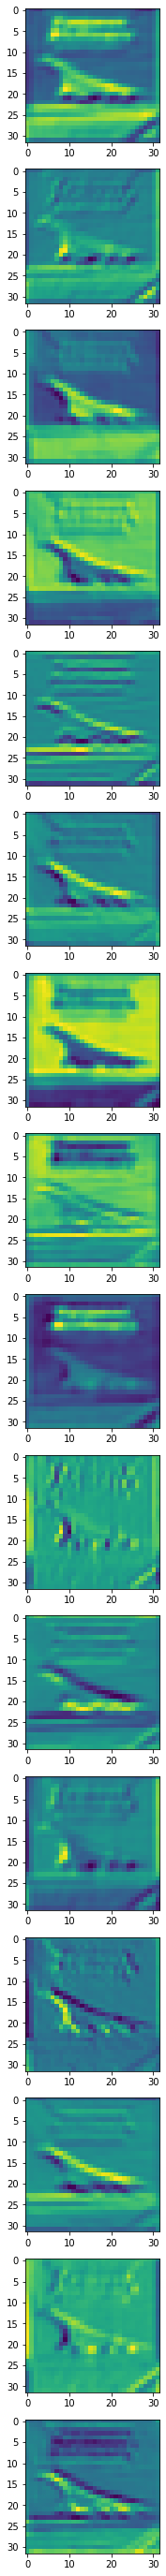

In [37]:
CIFAR_CNN.conv1.register_forward_hook(get_activation('conv3'))
image = example_data[3]
image.unsqueeze_(0)
output = CIFAR_CNN(image)
act = activation['conv3'].squeeze()
fig, axarr = plt.subplots(act.size(0))
fig.set_size_inches(50,50)
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])  